# MCM2022-C题

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import xgboost

%matplotlib inline

导入数据并去重。

In [174]:
# - Date: The date in mm-dd-yyyy (month-day-year) format.
# - Value: The price in U.S. dollars of a single bitcoin on the indicated date
LABEL_BITCOIN_VALUE = 'Value'
LABEL_DATE = 'Date'
bitcoin_trading = pd.read_csv('./BCHAIN-MKPRU.csv')
bitcoin_trading[LABEL_DATE] = pd.to_datetime(bitcoin_trading[LABEL_DATE])
count = bitcoin_trading.shape[0]
bitcoin_trading.drop_duplicates(subset=LABEL_DATE, keep='first', inplace=True)
if count != bitcoin_trading.shape[0]:
    print('Duplicate dates in bitcoin_trading')

# - Date: The date in mm-dd-yyyy (month-day-year) format.
# - USD (PM): The closing price of a troy ounce of gold in U.S. dollars on the indicated date.
LABEL_GOLD_VALUE = 'USD (PM)'
gold_trading = pd.read_csv('./LBMA-GOLD.csv')
gold_trading[LABEL_DATE] = pd.to_datetime(gold_trading[LABEL_DATE])

nan_count = gold_trading[LABEL_GOLD_VALUE].isnull().sum()
print('NaN before removed: ' + str(nan_count))

gold_trading = gold_trading.interpolate()  # ！使用插值法解决缺失值
nan_count = gold_trading[LABEL_GOLD_VALUE].isnull().sum()
print('NaN after removed: ' + str(nan_count))

count = gold_trading.shape[0]
duplicates = gold_trading.drop_duplicates(
    subset=LABEL_DATE, keep='first', inplace=True)
if count != gold_trading.shape[0]:
    print('Duplicate dates in gold_trading')


NaN before removed: 10
NaN after removed: 0


Text(0, 0.5, 'Gold Closing Price(dollars/ounce)')

<Figure size 432x288 with 0 Axes>

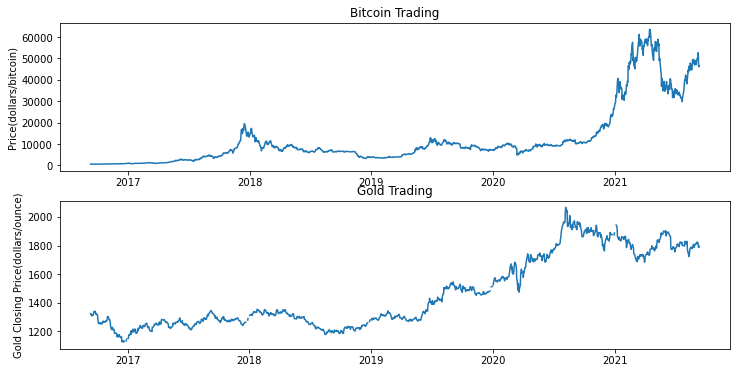

In [11]:
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.figure(figsize=(12, 6))

plt.subplot(2,1,1)
plt.title('Bitcoin Trading')
plt.plot(bitcoin_trading[LABEL_DATE], bitcoin_trading[LABEL_BITCOIN_VALUE])
plt.ylabel('Price(dollars/bitcoin)')

plt.subplot(2,1,2)
plt.title('Gold Trading')
plt.plot(gold_trading[LABEL_DATE], gold_trading[LABEL_GOLD_VALUE])
plt.ylabel('Gold Closing Price(dollars/ounce)')


In [12]:
DOLLARS = 0
OUNCE = 1
BITCOIN = 2

assets = [1000, 0, 0]

def show_assets(assets):
    print('Assets: {}$, {} oz, {} btc'.format(assets[DOLLARS], assets[OUNCE], assets[BITCOIN]))

show_assets(assets)

Assets: 1000$, 0 oz, 0 btc


In [154]:
from xgboost_helper import *

## 尝试训练模型并对样本做出预测

使用最后$n\_test$条数据作为测试数据，其余数据作为训练数据。我们发现前面的测试数据拟合的效果非常好，但是随着时间推移拟合效果变差（到后面直接变成直线了），不是很了解XGBoost工作原理，所以不知道为什么。

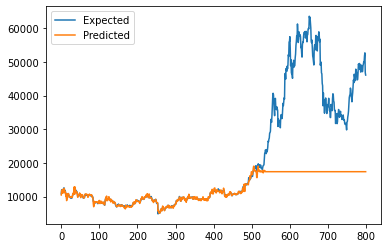

In [152]:
data = series_to_supervised(bitcoin_trading.values, n_in=5)
# n_test = int(data.shape[0] * 0.5)
n_test = 800
mae, y, yhat = walk_forward_validation(data, n_test)
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

## 训练模型

Test MAE: 8976.462


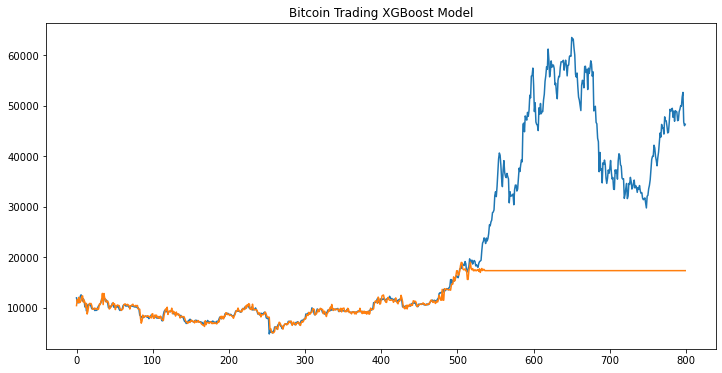

In [155]:
STEPS_IN = 5
ALWAYS_RETRAIN = True # If true, always retrain the model. If false, only retrain if the error is greater than the previous error.
MODEL_PATH_BITCOIN = os.path.abspath(os.path.join(os.path.curdir, 'bitcoin.model'))
N_TEST = 800

def load_bitcoin_model(to_predict=True, n_test=120):
    model = xgboost.XGBRegressor(
        objective='reg:squarederror', n_estimators=1000)
    data = series_to_supervised(bitcoin_trading.values, n_in=5)
    train, test = train_test_split(data, n_test)
    if os.path.exists(MODEL_PATH_BITCOIN):
        model.load_model(MODEL_PATH_BITCOIN)
    else:
        data = series_to_supervised(bitcoin_trading.values, n_in=STEPS_IN)
        train_x, train_y = train[:, :-1], train[:, -1]
        model.fit(train_x, train_y)
        model.save_model(MODEL_PATH_BITCOIN)

    if to_predict:
        test_x, test_y = test[:, :-1], test[:, -1]
        yhat = model.predict(test_x)
        error = mean_absolute_error(test_y, yhat)
        print('Test MAE: %.3f' % error)
    return model, test_y, yhat

if ALWAYS_RETRAIN and os.path.exists(MODEL_PATH_BITCOIN):
    os.remove(MODEL_PATH_BITCOIN)
    
btc_model, expected, predicted = load_bitcoin_model(n_test=N_TEST)
plt.figure(figsize=(12, 6))
plt.title('Bitcoin Trading XGBoost Model')
plt.plot(expected, label='Expected')
plt.plot(predicted, label='Predicted')
plt.show()


### 简单预测

下面的数据选取是从CSV中选的一段。由于数据有可能来自训练集部分，所以这两条数据可能会被过拟合，参考价值不大。

In [144]:
btc_model.predict([
    [9197.54, 9569.21, 9425.98, 9698.1, 9450.84],  # 10204.23
    [50110.53, 49075.58, 54056.64, 55071.46, 54884.1]  # 53584.15
])


array([ 9824.534, 17374.531], dtype=float32)

### 分批测试模型

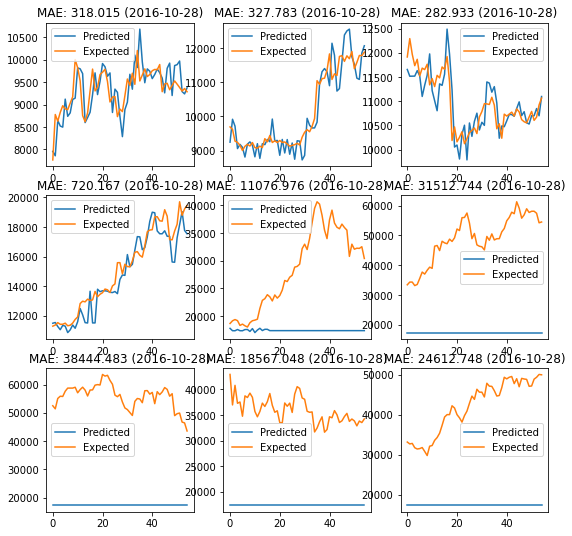

In [145]:
import random

cols = 3
rows = 3
n_batches = cols * rows
batch_size = int(test.shape[0] / n_batches)
plt.figure(figsize=(9, 9))
for y in range(rows):
    for x in range(cols):
        batch_start_index = (y * cols + x) * batch_size
        batch = test[batch_start_index:min(
            batch_start_index+batch_size, bitcoin_trading.shape[0]), :]
        test_x, test_y = batch[:, :-1], batch[:, -1]
        yhat = btc_model.predict(test_x)
        error = mean_absolute_error(test_y, yhat)
        plt.subplot(rows, cols, y * cols + x + 1)
        plt.plot(yhat, label='Predicted')
        plt.plot(test_y, label='Expected')
        plt.title('MAE: %.3f (%s)' %
                  (error, bitcoin_trading.iat[index, 0].strftime('%Y-%m-%d')))
        plt.legend()
plt.show()


## 精准训练

前面的模型主要是测试用某一段数据做出训练，并用该模型来预测以后的所有值，所以到了后面的预测效果越来越差，现在尝试针对某一天的预测，总是使用这一天之前的数据数据做训练。

**!!!下面这段代码的运行时间可能会很长，请谨慎重新运行。**

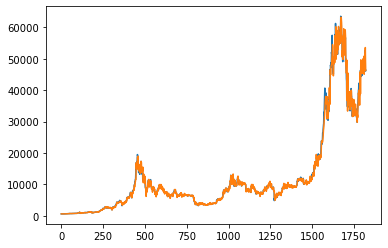

In [151]:
predictions = list()
expected = list()
data = series_to_supervised(bitcoin_trading.values, n_in=STEPS_IN)
for day in range(bitcoin_trading.shape[0])-1:
    train, test = data[:day+1], data[day+1:]
    train_x, train_y = train[:, :-1], train[:, -1]

    print('> Training on %d samples' % len(train_x))
    model = xgboost.XGBRegressor(
        objective='reg:squarederror', n_estimators=1000,
        tree_method='hist', gpu_id=0)
    model.fit(train_x, train_y)
    yhat = model.predict([test[0, :-1]])

    print('> Predicted=%f, Expected=%f' % (yhat, test[0, -1]))

    predictions.append(yhat[0])
    expected.append(test[0, -1])

plt.plot(expected, label='Expected')
plt.plot(predictions, label='Predicted')

## 模型训练结论

经过上面的训练，对下一天的结果的预测的准确性很大程度上受训练样本的影响：距离训练样本的时间越久，得到的预测的结果与实际的值的偏差会越来越大；反之，与预测的结果会拟合的越来越好。

In [146]:
handled_data = series_to_supervised(bitcoin_trading.values, n_in=5)
train, test = train_test_split(handled_data, N_TEST)
train.shape

(1021, 6)